## KALMAN FILTER

In [1]:
import numpy as np

def kalman(x, d, N = 64, sgm2v=1e-4):
    nIters = min(len(x),len(d)) - N
    u = np.zeros(N)
    w = np.zeros(N)
    Q = np.eye(N)*sgm2v
    P = np.eye(N)*sgm2v
    I = np.eye(N)
    e = np.zeros(nIters)
    x_hat = np.zeros(nIters)
    for n in range(nIters):
        u[1:] = u[:-1]
        u[0] = x[n]
        x_hat[n] = np.dot(u, w)
        e_n =  d[n] - np.dot(u, w)
        R = e_n**2+1e-10
        Pn = P + Q
        r = np.dot(Pn,u)
        K = r / (np.dot(u, r) + R + 1e-10)
        w = w + np.dot(K, e_n)
        P = np.dot(I - np.outer(K, u), Pn)
        e[n] = e_n

    return x_hat, e

## RECURSIVE LEAST SQUARES

In [2]:
import numpy as np

def rls(x, d, N = 4, lmbd = 0.999, delta = 0.01):
    nIters = min(len(x),len(d)) - N
    lmbd_inv = 1/lmbd
    u = np.zeros(N)
    w = np.zeros(N)
    P = np.eye(N)*delta
    e = np.zeros(nIters)
    x_hat = np.zeros(nIters)
    for n in range(nIters):
        u[1:] = u[:-1]
        u[0] = x[n]
        x_hat[n] = np.dot(u,w)
        e_n = d[n] - np.dot(u, w)
        r = np.dot(P, u)
        g = r / (lmbd + np.dot(u, r))
        w = w + e_n * g
        P = lmbd_inv*(P - np.outer(g, np.dot(u, P)))
        e[n] = e_n
    return x_hat, e

## AFFINE PROJECTION ALGORITHM

In [3]:
import numpy as np

def apa(x, d, N = 4, P = 4, mu = 0.1):
    nIters = min(len(x),len(d)) - N
    u = np.zeros(N)
    A = np.zeros((N,P))
    D = np.zeros(P)
    w = np.zeros(N)
    e = np.zeros(nIters)
    x_hat = np.zeros(nIters)
    alpha = np.eye(P)*1e-2
    for n in range(nIters):
        u[1:] = u[:-1]
        u[0] = x[n]
        A[:,1:] = A[:,:-1]
        A[:,0] = u
        D[1:] = D[:-1]
        D[0] = d[n] 
        e_n = D - np.dot(A.T, w)
        x_hat[n] = np.dot(A.T, w)[0]
        delta = np.dot(np.linalg.inv(np.dot(A.T,A)+alpha),e_n)
        w = w + mu * np.dot(A ,delta)
        e[n] = e_n[0]
    return x_hat, e

## NORMALIZED LEAST MEAN SQUARES

In [4]:
import numpy as np

def nlms(x, d, N=4, mu=0.1):
    nIters = min(len(x),len(d)) - N
    u = np.zeros(N)
    w = np.zeros(N)
    e = np.zeros(nIters)
    x_hat = np.zeros(nIters)
    for n in range(nIters):
        u[1:] = u[:-1]
        u[0] = x[n]
        e_n = d[n] - np.dot(u, w)
        x_hat[n] = np.dot(u,w)
        w = w + mu * e_n * u / (np.dot(u,u)+1e-3)
        e[n] = e_n
    return x_hat, e

## Frequency Domain Adaptive Filter

In [5]:
import numpy as np
from numpy.fft import rfft as fft
from numpy.fft import irfft as ifft

def fdaf(x, d, M, mu=0.05, beta=0.9):
    H = np.zeros(M+1,dtype=np.complex)
    norm = np.full(M+1,1e-8)

    window =  np.hanning(M)
    x_old = np.zeros(M)

    num_block = min(len(x),len(d)) // M
    e = np.zeros(num_block*M)
    x_hat = np.zeros(num_block*M)

    for n in range(num_block):
        x_n = np.concatenate([x_old,x[n*M:(n+1)*M]])
        d_n = d[n*M:(n+1)*M]
        x_old = x[n*M:(n+1)*M]

        X_n = fft(x_n)
        y_n = ifft(H*X_n)[M:]
        e_n = d_n-y_n
        e[n*M:(n+1)*M] = e_n
        x_hat[n*M:(n+1)*M] = y_n

        e_fft = np.concatenate([np.zeros(M),e_n*window])
        E_n = fft(e_fft)

        norm = beta*norm + (1-beta)*np.abs(X_n)**2
        G = mu*E_n/(norm+1e-3)
        H = H + X_n.conj()*G

        h = ifft(H)
        h[M:] = 0
        H = fft(h)

    return x_hat, e

## FREQUENCY DOMAIN KALMAN FILTER

In [6]:
import numpy as np
from numpy.fft import rfft as fft
from numpy.fft import irfft as ifft

def fdkf(x, d, M, beta=0.95, sgm2u=1e-2, sgm2v=1e-6):
    Q = sgm2u
    R = np.full(M+1,sgm2v)
    H = np.zeros(M+1,dtype=np.complex)
    P = np.full(M+1,sgm2u)

    window =  np.hanning(M)
    x_old = np.zeros(M)

    num_block = min(len(x),len(d)) // M
    e = np.zeros(num_block*M)
    x_hat = np.zeros(num_block*M)

    for n in range(num_block):
        x_n = np.concatenate([x_old,x[n*M:(n+1)*M]])
        d_n = d[n*M:(n+1)*M]
        x_old = x[n*M:(n+1)*M]

        X_n = np.fft.rfft(x_n)

        y_n = ifft(H*X_n)[M:]
        e_n = d_n-y_n
        x_hat[n*M:(n+1)*M] = y_n

        e_fft = np.concatenate([np.zeros(M),e_n*window])
        E_n = fft(e_fft)

        R = beta*R + (1.0 - beta)*(np.abs(E_n)**2)
        P_n = P + Q*(np.abs(H))
        K = P_n*X_n.conj()/(X_n*P_n*X_n.conj()+R)
        P = (1.0 - K*X_n)*P_n 

        H = H + K*E_n
        h = ifft(H)
        h[M:] = 0
        H = fft(h)

        e[n*M:(n+1)*M] = e_n
  
    return x_hat, e

## Partitioned-Block-Based Frequency Domain Adaptive Filter

In [7]:
import numpy as np
from numpy.fft import rfft as fft
from numpy.fft import irfft as ifft

class PFDAF:
    def __init__(self, N, M, mu, partial_constrain):
        self.N = N
        self.M = M
        self.N_freq = 1+M
        self.N_fft = 2*M
        self.mu = mu
        self.partial_constrain = partial_constrain
        self.p = 0
        self.x_old = np.zeros(self.M,dtype=np.float32)
        self.X = np.zeros((N,self.N_freq),dtype=np.complex)
        self.H = np.zeros((self.N,self.N_freq),dtype=np.complex)
        self.window = np.hanning(self.M)

    def filt(self, x, d):
        assert(len(x) == self.M)
        x_now = np.concatenate([self.x_old,x])
        X = fft(x_now)
        self.X[1:] = self.X[:-1]
        self.X[0] = X
        self.x_old = x
        Y = np.sum(self.H*self.X,axis=0)
        y = ifft(Y)[self.M:]
        e = d-y
        return e, y

    def update(self,e):
        X2 = np.sum(np.abs(self.X)**2,axis=0)
        e_fft = np.zeros(shape=(self.N_fft,),dtype=np.float32)
        e_fft[self.M:] = e*self.window
        E = fft(e_fft)

        G = self.mu*E/(X2+1e-10)
        self.H += self.X.conj()*G

        if self.partial_constrain:
            h = ifft(self.H[self.p])
            h[self.M:] = 0
            self.H[self.p] = fft(h)
            self.p = (self.p + 1) % self.N
        else:
            for p in range(self.N):
                h = ifft(self.H[p])
                h[self.M:] = 0
                self.H[p] = fft(h)

def pfdaf(x, d, N=4, M=64, mu=0.2, partial_constrain=True):
    ft = PFDAF(N, M, mu, partial_constrain)
    num_block = min(len(x),len(d)) // M

    e = np.zeros(num_block*M)
    x_hat = np.zeros(num_block*M)
    for n in range(num_block):
        x_n = x[n*M:(n+1)*M]
        d_n = d[n*M:(n+1)*M]
        e_n, x_h = ft.filt(x_n,d_n)
        ft.update(e_n)
        e[n*M:(n+1)*M] = e_n
        x_hat[n*M:(n+1)*M] = x_h
    
    return x_hat, e

## Partitioned-Block-Based Frequency Domain Kalman Filter

In [8]:
import numpy as np
from numpy.fft import rfft as fft
from numpy.fft import irfft as ifft

class PFDKF:
    def __init__(self,N,M,A=0.999,P_initial=1e+2, partial_constrain=True):
        self.N = N
        self.M = M
        self.N_freq = 1+M
        self.N_fft = 2*M
        self.A2 = A**2
        self.partial_constrain = partial_constrain
        self.p = 0

        self.x = np.zeros(shape=(2*self.M),dtype=np.float32)
        self.P = np.full((self.N,self.N_freq),P_initial)
        self.X = np.zeros((N,self.N_freq),dtype=np.complex)
        self.window = np.hanning(self.M)
        self.H = np.zeros((self.N,self.N_freq),dtype=np.complex)

    def filt(self, x, d):
        assert(len(x) == self.M)
        self.x[self.M:] = x
        X = fft(self.x)
        self.X[1:] = self.X[:-1]
        self.X[0] = X
        self.x[:self.M] = self.x[self.M:]
        Y = np.sum(self.H*self.X,axis=0)
        y = ifft(Y)[self.M:]
        e = d-y
        return e,y

    def update(self, e):
        e_fft = np.zeros(shape=(self.N_fft,),dtype=np.float32)
        e_fft[self.M:] = e*self.window
        E = fft(e_fft)
        X2 = np.sum(np.abs(self.X)**2,axis=0)
        Pe = 0.5*self.P*X2 + np.abs(E)**2/self.N
        mu = self.P / (Pe + 1e-10)
        self.P = self.A2*(1 - 0.5*mu*X2)*self.P + (1-self.A2)*np.abs(self.H)**2
        G = mu*self.X.conj()
        self.H += E*G

        if self.partial_constrain:
            h = ifft(self.H[self.p])
            h[self.M:] = 0
            self.H[self.p] = fft(h)
            self.p = (self.p + 1) % self.N
        else:
            for p in range(self.N):
                h = ifft(self.H[p])
                h[self.M:] = 0
                self.H[p] = fft(h)

def pfdkf(x, d, N=4, M=64, A=0.999,P_initial=1e+2, partial_constrain=True):
    ft = PFDKF(N, M, A, P_initial, partial_constrain)
    num_block = min(len(x),len(d)) // M

    e = np.zeros(num_block*M)
    x_hat = np.zeros(num_block*M)
    for n in range(num_block):
        x_n = x[n*M:(n+1)*M]
        d_n = d[n*M:(n+1)*M]
        e_n, x_h = ft.filt(x_n,d_n)
        ft.update(e_n)
        e[n*M:(n+1)*M] = e_n
        x_hat[n*M:(n+1)*M] = x_h
    return x_hat, e

## Adaptive Exponential Functional Link Adaptive Filter

In [9]:
import numpy as np

def aeflaf(x, d, M=128, P=5, mu=0.2, mu_a=0.1):
    nIters = min(len(x),len(d)) - M
    Q = P*2
    u = np.zeros(M)
    w = np.zeros((Q+1)*M)
    a = 0
    e = np.zeros(nIters)
    x_hat = np.zeros(nIters)
    sk = np.zeros(P*M,dtype=np.int32)
    ck = np.zeros(P*M,dtype=np.int32)
    pk = np.tile(np.arange(P),M)
    for k in range(M):
        sk[k*P:(k+1)*P] = np.arange(1,Q,2) + k*(Q+1)
        ck[k*P:(k+1)*P] = np.arange(2,Q+1,2) + k*(Q+1)
    for n in range(nIters):
        u[1:] = u[:-1]
        u[0] = x[n]
        g = np.repeat(u,Q+1)
        g[sk] = np.exp(-a*abs(g[sk]))*np.sin(np.pi*pk*g[sk])
        g[ck] = np.exp(-a*abs(g[ck]))*np.cos(np.pi*pk*g[ck])
        y = np.dot(w, g.T)
        e_n = d[n] - y
        x_hat[n] = y
        w = w + mu*e_n*g/(np.dot(g,g)+1e-3)
        z = np.repeat(u,Q+1)
        z[sk] = -abs(z[sk])*g[sk]
        z[ck] = -abs(z[ck])*g[ck]
        z[np.arange(M)*Q] = 0
        grad_a = np.dot(z,w)
        a = a + mu_a*e_n*grad_a/(grad_a**2+1e-3)
        e[n] = e_n
    return x_hat, e

## Collaborative Functional Link Adaptive Filter

In [10]:
import numpy as np

def cflaf(x, d, M=128, P=5, mu_L=0.2, mu_FL=0.5, mu_a=0.5):
    nIters = min(len(x),len(d)) - M
    Q = P*2
    beta = 0.9
    sk = np.arange(0,Q*M,2)
    ck = np.arange(1,Q*M,2)
    pk = np.tile(np.arange(P),M)
    u = np.zeros(M)
    w_L = np.zeros(M)
    w_FL = np.zeros(Q*M)
    alpha = 0
    gamma = 1
    e = np.zeros(nIters) 
    x_hat = np.zeros(nIters)
    for n in range(nIters):
        u[1:] = u[:-1]
        u[0] = x[n]
        g = np.repeat(u,Q)
        g[sk] = np.sin(pk*np.pi*g[sk])
        g[ck] = np.cos(pk*np.pi*g[ck])
        y_L = np.dot(w_L, u.T)
        y_FL = np.dot(w_FL,g.T)
        e_FL = d[n] - (y_L+y_FL)
        w_FL = w_FL + mu_FL * e_FL * g / (np.dot(g,g)+1e-3)
        lambda_n = 1 / (1 + np.exp(-alpha))
        y_N = y_L + lambda_n*y_FL
        e_n = d[n] - y_N
        x_hat[n] = y_N
        gamma = beta*gamma + (1-beta)*(y_FL**2)
        alpha = alpha + (mu_a*e_n*y_FL*lambda_n*(1-lambda_n) /  gamma)
        alpha = np.clip(alpha,-4,4)
        w_L = w_L + mu_L*e_n*u/(np.dot(u,u)+1e-3)
        e[n] = e_n
    return x_hat, e

In [18]:
def save_figs(x, x_hat, sr, filter_name):
    fig = plt.figure(figsize=(30, 20))
    plt.subplot(2,1,1)
    plt.specgram(x,Fs=sr)
    plt.title("Original noisy audio", fontsize=20)
    plt.xlabel("Time", fontsize=20)
    plt.ylabel("Frequency", fontsize=20)
    plt.subplot(2,1,2)
    plt.specgram(x_hat,Fs=sr)
    plt.title("Filtered audio", fontsize=20)
    plt.xlabel("Time", fontsize=20)
    plt.ylabel("Frequency", fontsize=20)
    plt.tight_layout(pad=5)
    plt.savefig("audio/results/"+filter_name+"/5dB/plots/"+file[:-4]+"_"+noise+"_sn5"+"_filtered_spectrogram.png", dpi=50)
    plt.close(fig)

In [19]:
snr_dat

def filter_all(d, x, sr, noise, file):
    print("Started:", noise, file)
    file_name = "cleaned_"+file[:-4]+"_"+noise+"_sn5"
    x_hat, error = kalman(x, d, N = 64, sgm2v=1e-4)
    sf.write('audio/results/kalman/5dB/wav/'+file_name+".wav", x_hat, sr, subtype='PCM_16')
    save_figs(x, x_hat, sr, "kalman")
    snr(x_hat, error)
    
    x_hat, error = rls(x, d, N = 4, lmbd = 0.999, delta = 0.01)
    sf.write('audio/results/rls/5dB/wav/'+file_name+".wav", x_hat, sr, subtype='PCM_16')
    save_figs(x, x_hat, sr, "rls")
    snr(x_hat, error)
    
    x_hat, error = apa(x, d, N = 4, P = 4, mu = 0.1)
    sf.write('audio/results/apa/5dB/wav/'+file_name+".wav", x_hat, sr, subtype='PCM_16')
    save_figs(x, x_hat, sr, "apa")
    snr(x_hat, error)
    
    x_hat, error = nlms(x, d, N=4, mu=0.1)
    sf.write('audio/results/nlms/5dB/wav/'+file_name+".wav", x_hat, sr, subtype='PCM_16')
    save_figs(x, x_hat, sr, "nlms")
    snr(x_hat, error)
    
    x_hat, error = fdaf(x, d, M=64, mu=0.05, beta=0.9)
    sf.write('audio/results/fdaf/5dB/wav/'+file_name+".wav", x_hat, sr, subtype='PCM_16')
    save_figs(x, x_hat, sr, "fdaf")
    snr(x_hat, error)
    
    x_hat, error = fdkf(x, d, M=64, beta=0.95, sgm2u=1e-2, sgm2v=1e-6)
    sf.write('audio/results/fdkf/5dB/wav/'+file_name+".wav", x_hat, sr, subtype='PCM_16')
    save_figs(x, x_hat, sr, "fdkf")
    snr(x_hat, error)
    
    x_hat, error = pfdaf(x, d, N=4, M=64, mu=0.2, partial_constrain=True)
    sf.write('audio/results/pfdaf/5dB/wav/'+file_name+".wav", x_hat, sr, subtype='PCM_16')
    save_figs(x, x_hat, sr, "pfdaf")
    snr(x_hat, error)
    
    x_hat, error = pfdkf(x, d, N=4, M=64, A=0.999,P_initial=1e+2, partial_constrain=True)
    sf.write('audio/results/pfdkf/5dB/wav/'+file_name+".wav", x_hat, sr, subtype='PCM_16')
    save_figs(x, x_hat, sr, "pfdkf")
    snr(x_hat, error)
    
    x_hat, error = aeflaf(x, d, M=128, P=5, mu=0.2, mu_a=0.1)
    sf.write('audio/results/aeflaf/5dB/wav/'+file_name+".wav", x_hat, sr, subtype='PCM_16')
    save_figs(x, x_hat, sr, "aeflaf")
    snr(x_hat, error)
    
    x_hat, error = cflaf(x, d, M=128, P=5, mu_L=0.2, mu_FL=0.5, mu_a=0.5)
    sf.write('audio/results/cflaf/5dB/wav/'+file_name+".wav", x_hat, sr, subtype='PCM_16')
    save_figs(x, x_hat, sr, "cflaf")
    snr(x_hat, error)

In [20]:
## Code begins here:
## Link for audio files: https://ecs.utdallas.edu/loizou/speech/noizeus/
## noisy file name pattern: "sp**_noisetype_sn**.wav"
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import librosa
import soundfile as sf
from glob import glob
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

audio_file_path = "./audio"
clean_audio = audio_file_path+"/clean"
noisy_audio_path = audio_file_path+"/noisy/allnoise_5dB"
files = [i[14:] for i in glob(clean_audio+"/*.wav")]
noise_types = ['restaurant', 'babble', 'exhibition', 'train', 'street']
for noise in noise_types:
    for file in files:
        x, sr = librosa.load(noisy_audio_path+"/"+file[:-4]+"_"+noise+"_sn5.wav")
        d, sr = librosa.load(clean_audio+"/"+file)
        filter_all(d, x, sr, noise, file)

Started: restaurant sp27.wav
Started: restaurant sp26.wav
Started: restaurant sp18.wav
Started: restaurant sp30.wav
Started: restaurant sp24.wav
Started: restaurant sp25.wav
Started: restaurant sp19.wav
Started: restaurant sp21.wav
Started: restaurant sp09.wav
Started: restaurant sp08.wav
Started: restaurant sp20.wav
Started: restaurant sp22.wav
Started: restaurant sp23.wav
Started: restaurant sp06.wav
Started: restaurant sp12.wav
Started: restaurant sp13.wav
Started: restaurant sp07.wav
Started: restaurant sp11.wav
Started: restaurant sp05.wav
Started: restaurant sp04.wav
Started: restaurant sp10.wav
Started: restaurant sp14.wav
Started: restaurant sp28.wav
Started: restaurant sp29.wav
Started: restaurant sp01.wav
Started: restaurant sp15.wav
Started: restaurant sp03.wav
Started: restaurant sp17.wav
Started: restaurant sp16.wav
Started: restaurant sp02.wav
Started: babble sp27.wav
Started: babble sp26.wav
Started: babble sp18.wav
Started: babble sp30.wav
Started: babble sp24.wav
Start

1. Initial simulink model-> FPGA & matlab
2. another instance of simulink model
3. We have real life data filtering using multiple adaptive filters-> plots and SNR data
4. Adaptive filters -> freq adaptation in software

In [21]:
import IPython

In [92]:
file = noisy_audio_path+"/sp01_train_sn5.wav"
IPython.display.Audio(file)

In [93]:
d, sr = librosa.load(file)

In [56]:
from numpy.fft import irfft as ifft
from scipy.fft import rfft, rfftfreq, irfft

frame_size = 128
hop_size = 32
x = np.zeros(len(d))
for i in range(0,len(d)-frame_size,frame_size):
    D = rfft(d[i:i+frame_size])
    x[i:i+frame_size] = irfft(1.2*D)

In [80]:
bp

array([-8.77339459e-04, -9.37038885e-04, -9.96482451e-04, ...,
        2.71927285e-08,  2.33024820e-08,  1.98647337e-08])

In [37]:
len(D), len(d)

(31049, 62096)

In [38]:
from scipy.fft import irfft

In [40]:
x = irfft(D)

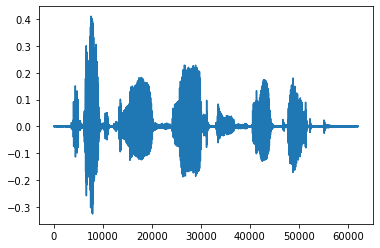

In [47]:
plt.plot(x)
plt.show()

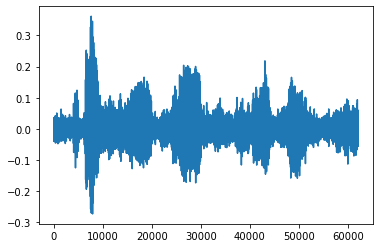

In [94]:
plt.plot(d)

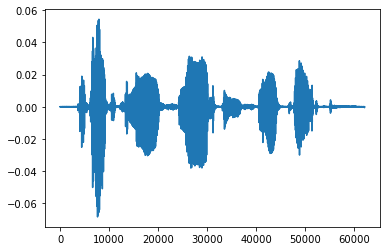

In [49]:
plt.plot(d-x)

In [71]:
sf.write("x.wav", bp, sr, subtype='FLOAT')

In [59]:
IPython.display.Audio(file)


In [89]:
IPython.display.Audio("x.wav")

In [95]:
from scipy.signal import butter, sosfiltfilt
from scipy.fft import fft, fftfreq
from scipy.signal import butter, lfilter

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b = butter(order, [low, high], btype='band', output='sos')
    return b

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b= butter_bandpass(lowcut, highcut, fs, order=order)
    y = sosfiltfilt(b, data)
    return y

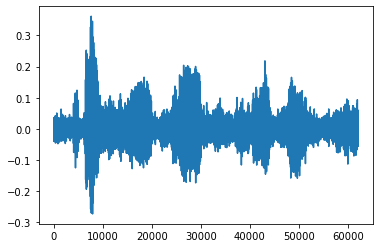

In [96]:
plt.plot(d)

In [103]:
bp = butter_bandpass_filter(d, 20, 1000, sr, order=3)

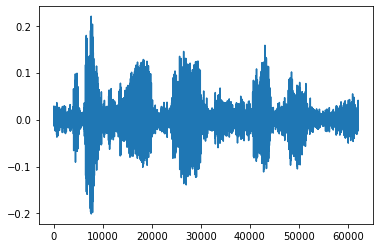

In [104]:
plt.plot(bp)

In [105]:
from scipy.io import wavfile
wavfile.write("x.wav", sr, bp)

In [129]:
## FB Starts from B8->C8]
##butter_bandpass(lowcut, highcut, fs, order=order)

fb_center_freq = [7902.13, 7040, 6271.93, 5587.65, 5274.04, 4698.63, 4186.01]
notes = ["B", "A", "G", "F", "E", "D", "C"]
filter_depth = 9
starting_q = 12
order = 3
fs = sr

filters = {}
for i in range(len(fb_center_freq)):
    for j in range(filter_depth):
        cf = fb_center_freq[i]/2**j
        bw = cf/starting_q
        lowcut = cf-bw/2
        highcut = cf+bw/2
        filters[notes[i]+str(8-j)] = butter_bandpass(lowcut, highcut, fs, order=order)

In [130]:
filters

{'B8': array([[ 9.41927617e-05,  1.88385523e-04,  9.41927617e-05,
          1.00000000e+00, -8.23102986e-01,  9.10319316e-01],
        [ 1.00000000e+00,  0.00000000e+00, -1.00000000e+00,
          1.00000000e+00, -7.68605254e-01,  9.53337650e-01],
        [ 1.00000000e+00, -2.00000000e+00,  1.00000000e+00,
          1.00000000e+00, -9.12702375e-01,  9.55073684e-01]]),
 'B7': array([[ 1.23195987e-05,  2.46391974e-05,  1.23195987e-05,
          1.00000000e+00, -1.65307338e+00,  9.54155939e-01],
        [ 1.00000000e+00,  0.00000000e+00, -1.00000000e+00,
          1.00000000e+00, -1.64951033e+00,  9.76084001e-01],
        [ 1.00000000e+00, -2.00000000e+00,  1.00000000e+00,
          1.00000000e+00, -1.69361940e+00,  9.77559899e-01]]),
 'B6': array([[ 1.57585250e-06,  3.15170501e-06,  1.57585250e-06,
          1.00000000e+00, -1.89915701e+00,  9.76815366e-01],
        [ 1.00000000e+00,  0.00000000e+00, -1.00000000e+00,
          1.00000000e+00, -1.90403354e+00,  9.87934039e-01],
        [ 

In [124]:
sr, y = wavfile.read("test.wav")

In [128]:
len(y[:,1])

7475136

In [126]:
sr

44100

In [132]:
filtered = {}

for i in filters:
    filtered[i] = sosfiltfilt(filters[i], y[:,1])

In [133]:
filtered

{'B8': array([-1.38793561e-147, -3.26685568e-147, -1.66869586e-147, ...,
         0.00000000e+000,  0.00000000e+000,  0.00000000e+000]),
 'B7': array([ 6.01929754e-075, -1.24777235e-074, -2.77750774e-074, ...,
        -1.13635099e-322, -1.08694442e-322, -7.41098469e-323]),
 'B6': array([9.28575122e-039, 1.46123015e-038, 1.89249779e-038, ...,
        1.66803304e-251, 1.01286939e-251, 4.17307925e-252]),
 'B5': array([ 1.23515573e-022, -7.57723408e-022, -1.63232642e-021, ...,
         7.96269276e-129,  7.90775599e-129,  7.62037821e-129]),
 'B4': array([-8.88072098e-12, -8.17487367e-12, -7.42920434e-12, ...,
        -5.28888281e-69, -4.47539651e-69, -3.74982211e-69]),
 'B3': array([-1.09595686e-05, -1.07881642e-05, -1.06056848e-05, ...,
        -6.02546536e-39, -5.11849931e-39, -4.31058875e-39]),
 'B2': array([ 2.96100566e-02,  3.16079029e-02,  3.35994752e-02, ...,
        -9.28068111e-25, -7.82433396e-25, -6.54176553e-25]),
 'B1': array([ 1.87311761e+00,  1.87372596e+00,  1.87419799e+00, 

In [137]:
for i in filtered:
    sf.write("filtered/test_"+i+".wav", filtered[i], sr, subtype='PCM_16')

In [140]:
summed = np.zeros(7475136)

for i in filtered:
    summed = summed + filtered[i]

In [141]:
summed

array([-6.00038114e+00, -5.93563704e+00, -5.87077444e+00, ...,
       -6.07725215e-14, -5.09241075e-14, -4.23218615e-14])

In [169]:
sf.write("filtered/summed.wav", np.real(summed), sr, subtype='PCM_16')

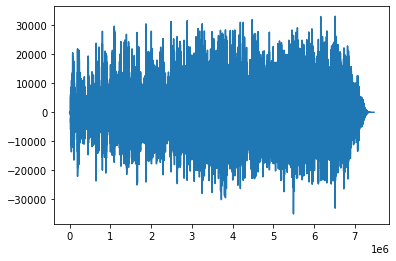

In [143]:
plt.plot(summed)

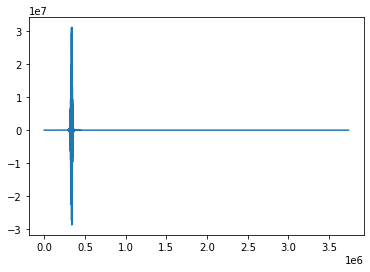

In [145]:
plt.plot(rfft(filtered["B6"]))

In [146]:
xf = rfftfreq(len(filtered["B8"]), 1./sr)

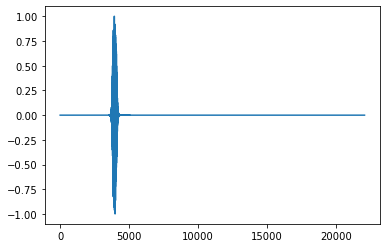

In [150]:
plt.plot(xf, rfft(filtered["B7"])/max(rfft(filtered["B7"])))

In [151]:
rfft_filtered = {}
for i in filtered:
    rfft_filtered[i] = rfft(filtered[i])

In [152]:
maxx = 0
for i in rfft_filtered:
    temp = max(rfft_filtered[i])
    if temp>maxx:
        maxx = temp

for i in rfft_filtered:
    rfft_filtered[i] = rfft_filtered[i]/maxx

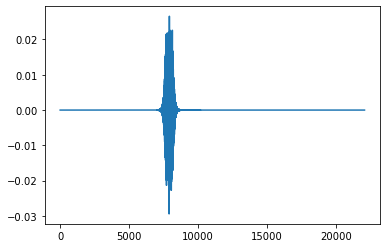

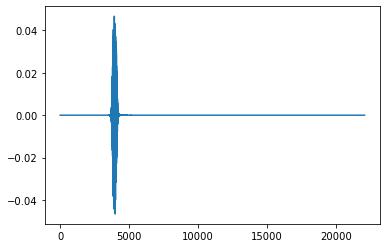

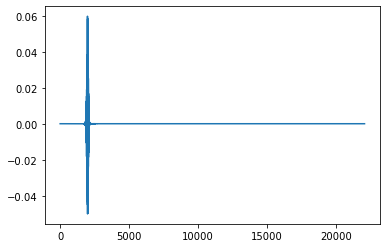

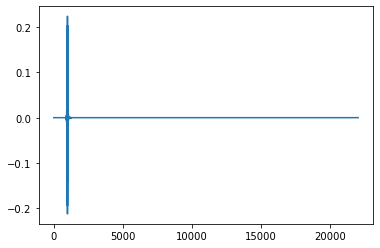

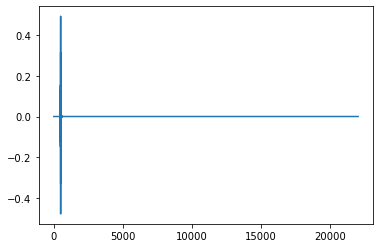

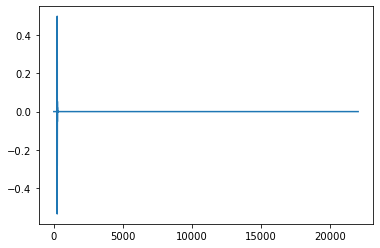

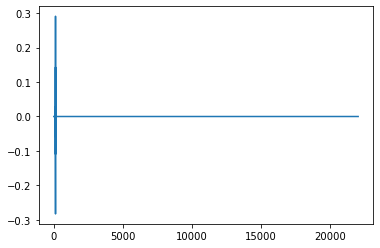

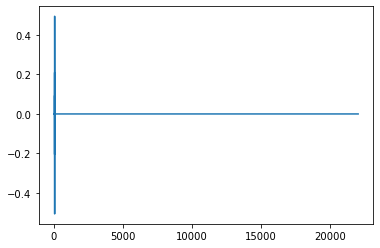

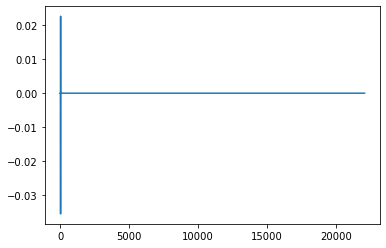

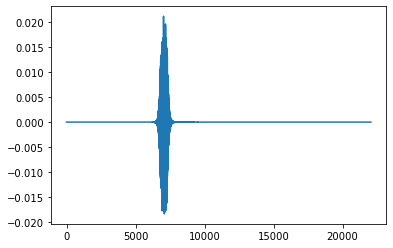

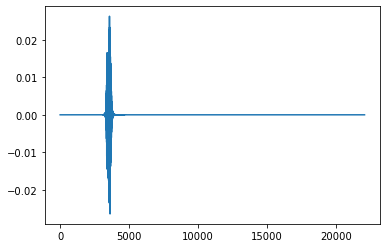

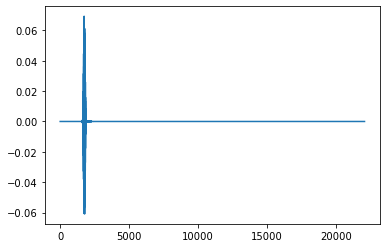

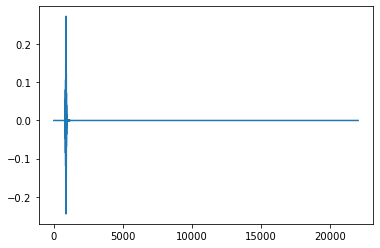

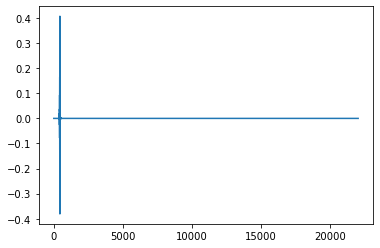

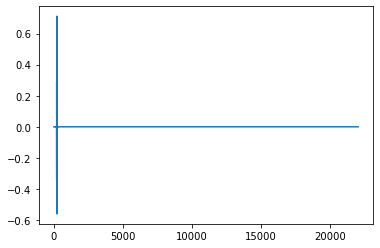

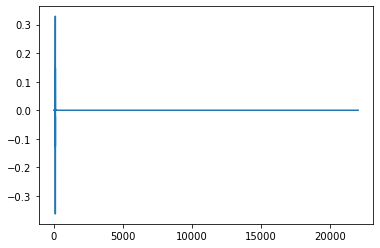

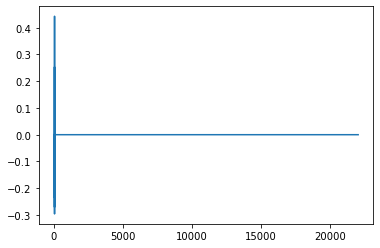

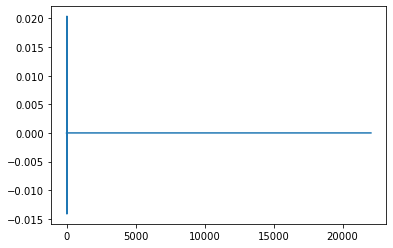

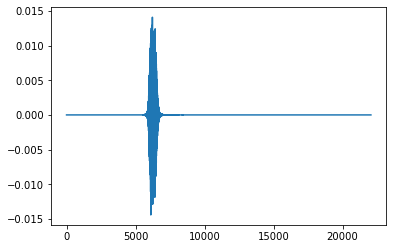

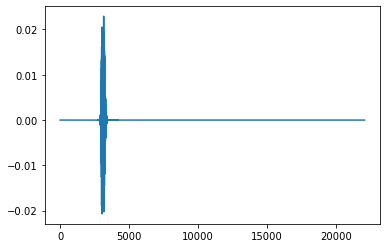

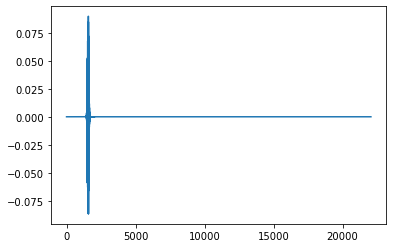

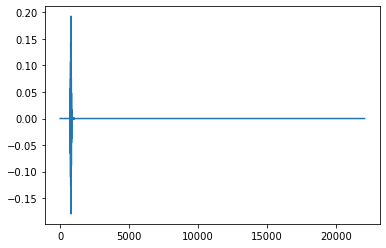

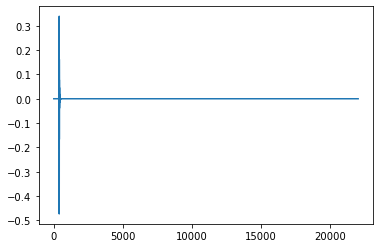

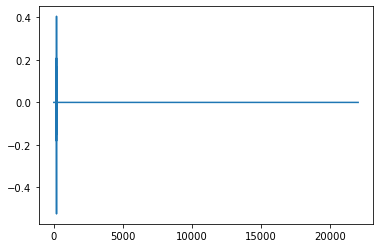

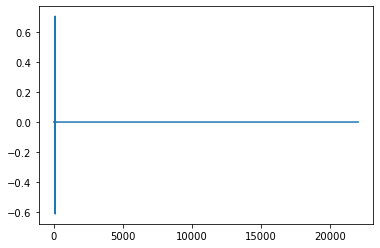

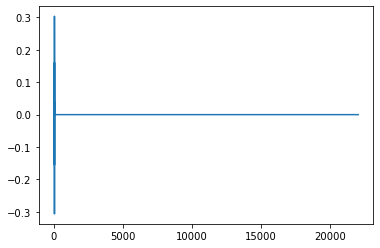

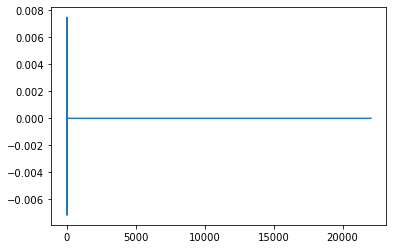

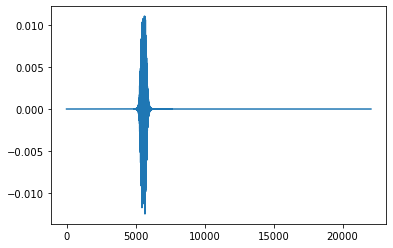

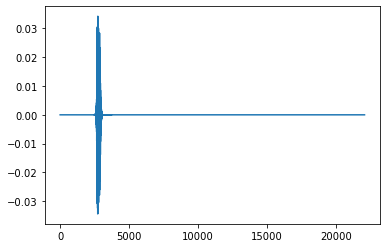

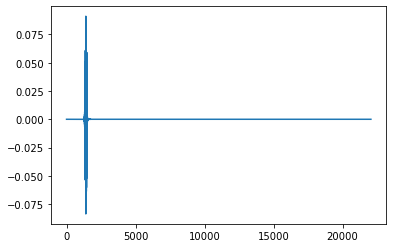

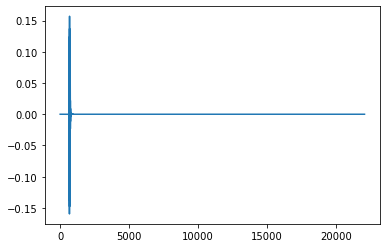

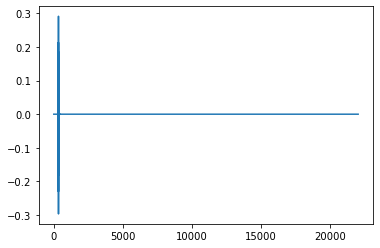

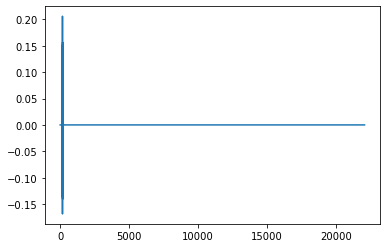

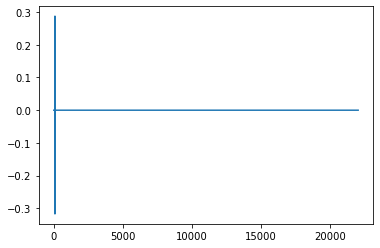

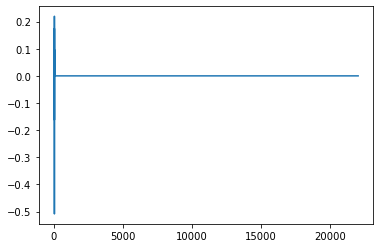

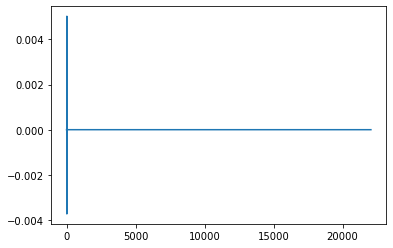

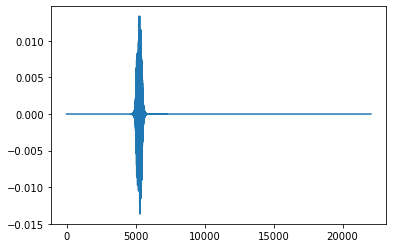

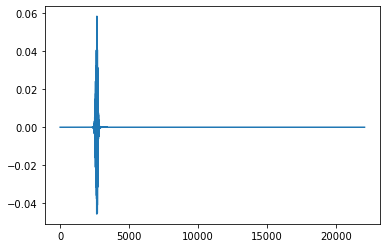

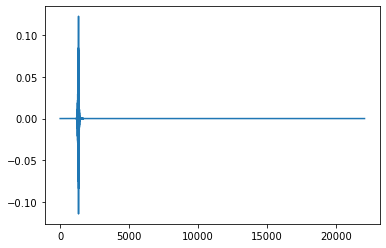

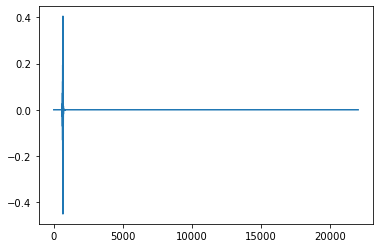

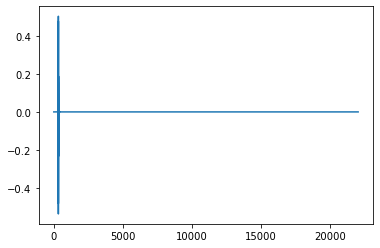

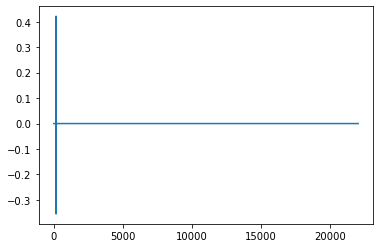

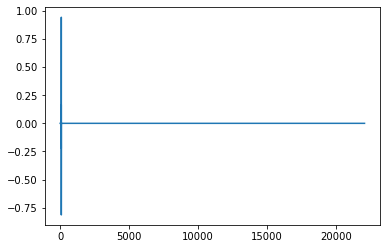

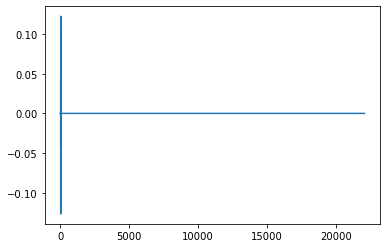

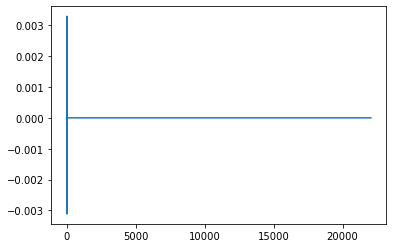

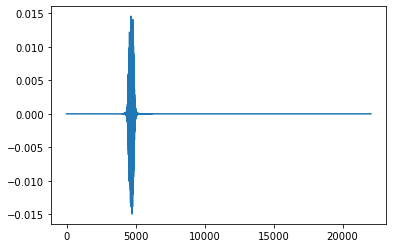

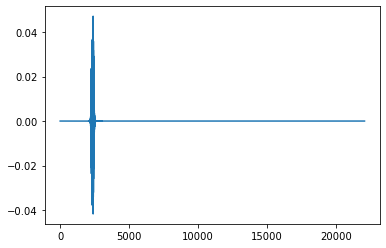

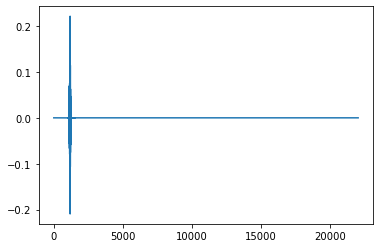

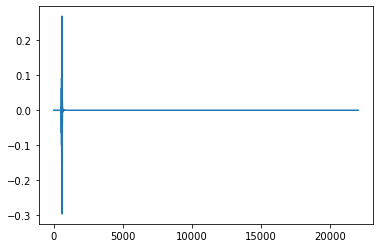

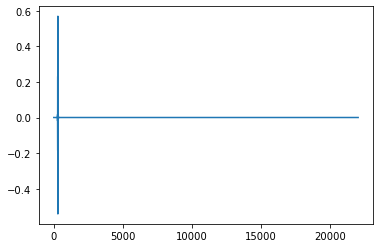

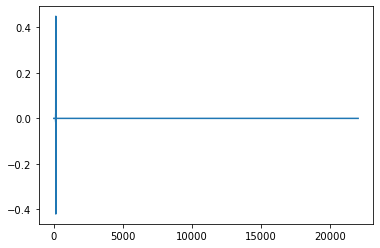

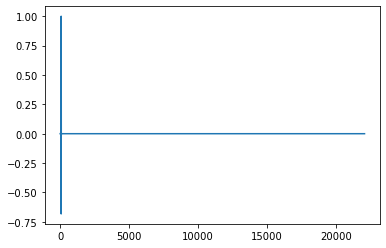

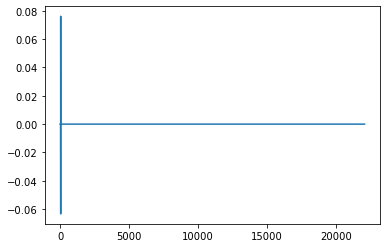

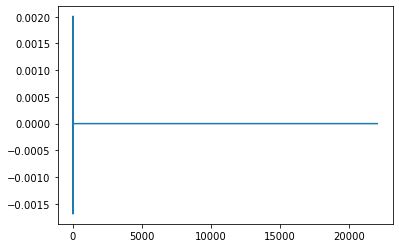

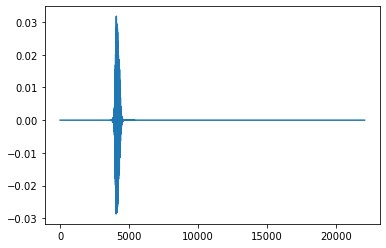

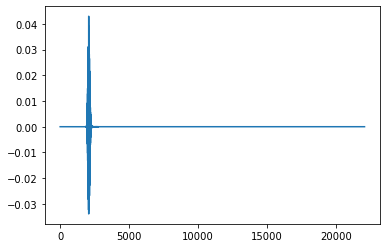

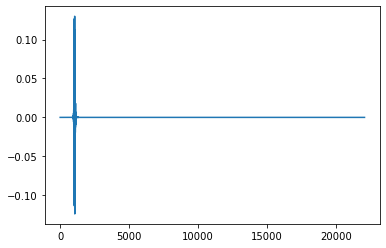

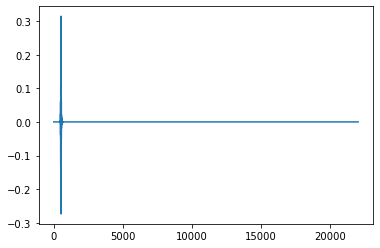

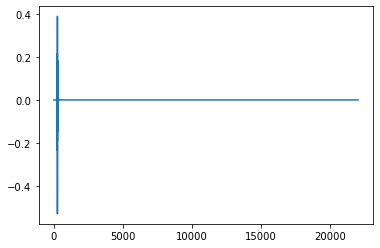

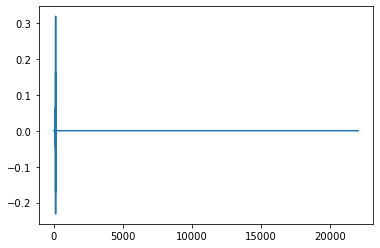

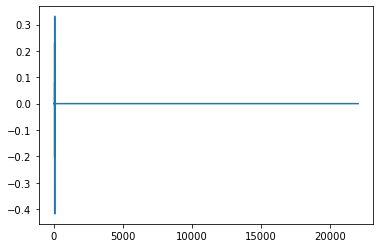

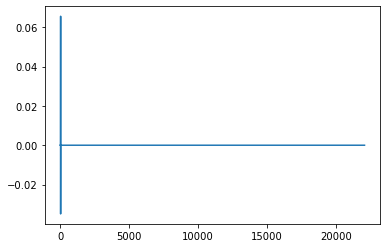

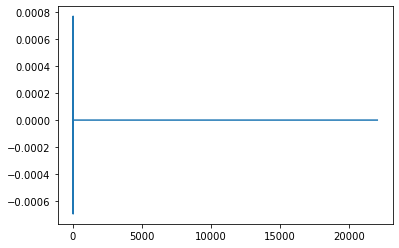

In [159]:
for i in rfft_filtered:
    plt.plot(xf, rfft_filtered[i])
    plt.show()

In [160]:
summed = np.zeros(7475136)

for i in filtered:
    summed = summed + max(rfft_filtered[i])*(filtered[i])

In [170]:
max(rfft_filtered["B8"])

(0.02658914235770122+0.0006444751043757293j)

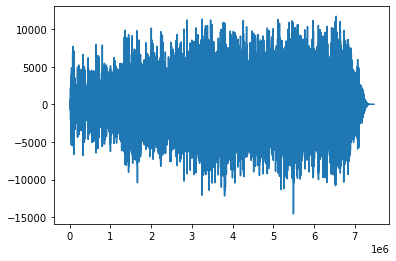

In [168]:
plt.plot(np.real(summed))